In [1]:
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Training Deep Neural Networks

Why would we need to use a deep neural net? Well say we are tackling a complex problem such as playing the gam eof go or generating auto-text. It can not actually be done well with shallow neural net. It is preferable to use a deep neural net. 

However it is difficult to train deep neural nets below are some problems you can face:

* You may be faced with the tricky vanishing gradient problem or the related exploding gradient problem. This is when teh gradients grow smaller and smaller or larger and larger, when folowing backward through the DNN during training. Both of these problems make lower layers very hard to train. 

* You might not have enough training for such a large netowrk, or it might be too costly to label.

* Training may be extremely slow.

* A model with millions of parameters would severly risk overfitting the training set, especially if there are not enough training instances or if they are too noisy. 

## The Vanishing/Exploding Gradient Problems

Backpropagation works by going back from the output layer to th einput layer propagating the error gradient along the way. Once the algorithm has computed the gradient the cost function with regard to each parameter in the network, it uses these gradients to update each parameter with the gradient descent step. 

The problem with this approach with deep neural nets is that as the gradients gets smaller as you go down the lower layers meaning you never update the weights. The training never converges to a good solution.  This is called **vanishing graidents** problem. Sometimes the opposite happens and the gradients get bigger and bigger. Until the layers get insanely large weights and the alogrithm diverges. This is called **exploding graidents**. It is important to remember that different layers may learn at very different speeds. 


In [2]:
def logit(z):
    return 1 / (1 + np.exp(-z))

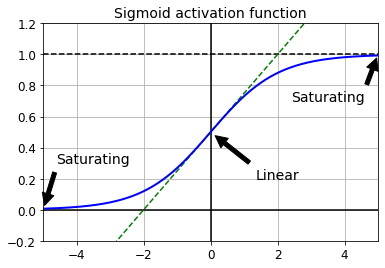

In [3]:
z = np.linspace(-5, 5, 200)

plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [1, 1], 'k--')
plt.plot([0, 0], [-0.2, 1.2], 'k-')
plt.plot([-5, 5], [-3/4, 7/4], 'g--')
plt.plot(z, logit(z), "b-", linewidth=2)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Saturating', xytext=(3.5, 0.7), xy=(5, 1), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Saturating', xytext=(-3.5, 0.3), xy=(-5, 0), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Linear', xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props, fontsize=14, ha="center")
plt.grid(True)
plt.title("Sigmoid activation function", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])

#save_fig("sigmoid_saturation_plot")
plt.show()

In the image above we see that when the inputs become large whether positive or negative the function saturates at 0 or 1 with a derivative extremely close to 0. When backpropagation kicks in it has varitually no gradient to progpagate back through the network and what little graidents exsts keeps getting diluted as backprogation progress down through the top layers so nothing left for the loower layers. 

## Glorot and He Initialization

In order to alleviate the unstable gradients problems. They point out that we need the signal  to flow properly in both directions: forward direction when making predictions and in the reverse direction when backpropagating gradients. We do not want the signal to die out nor do we want it to explode and saturate. 

For the signal to flow properly we need the variance of the outputs of each layer to be equal to the variance of inputs  and we need the gradients to have equal variance before an after flowing through a layer in the reverse direction. 

It is not actually possible to guarantee both they layer has an equal number of inputs and neurons these numbers are called the fan-in and fan-out of the layer. The solution to this was to make the connection weights of each layer innitialized randomly as described by fanavvg = (fanin + fanoout)/2. This initilization strategy is called Xavier initialization or Glorot initialization. 

Keras uses Glorot initialization with a uniform distribution. When creating a alyer, you can chnaget this to He initialization by setting **kernel_initializer="he_uniform"**.

In [4]:
[name for name in dir(keras.initializers) if not name.startswith("_")]

['Constant',
 'GlorotNormal',
 'GlorotUniform',
 'Identity',
 'Initializer',
 'Ones',
 'Orthogonal',
 'RandomNormal',
 'RandomUniform',
 'TruncatedNormal',
 'VarianceScaling',
 'Zeros',
 'constant',
 'deserialize',
 'get',
 'glorot_normal',
 'glorot_uniform',
 'he_normal',
 'he_uniform',
 'identity',
 'lecun_normal',
 'lecun_uniform',
 'ones',
 'orthogonal',
 'serialize',
 'zeros']

In [5]:
keras.layers.Dense(10, activation="relu", kernel_initializer="he_normal")

In [6]:
init = keras.initializers.VarianceScaling(scale=2., mode='fan_avg',
                                          distribution='uniform')
keras.layers.Dense(10, activation="relu", kernel_initializer=init)

## Nonsaturating activation Functions 

One of the reasons we had a problem with unstable gradients were in part due to poor activation function choices. The ReLu function works well because it does not saturate for paositive values and it is fast to compute. 

Some challenges with ReLu are that sometimes it just outputs 0. THis is called "dying ReLUs". This can happen if you have a large learning rate. 

Neurons die when its weights get tweaked in such a way that the weighted sum of is inputs are negative for all instances in the training set.  

To solve this problem you can use a variant of ReLU like "Leaky ReLU". The hyperparameter for the learning rate defines how much of the function "leaks". 